#### Parameter Estimation 1
$$min \sum ((X_{1}(t_{i}) - X_{1,meas}(t_i))^{2})$$
$$s.t \;\; X_{1,dot} = X_{2} \;\;\;\;\;\;\;\; X_{1}(0) = p_{1}$$
$$\;\; X_{2,dot} = 1-2*X_{2}-X_{1} \;\;\;\;\;\;\;\; X_{2}(0) = p_{2}$$
$$-1.5 \leq p_{1}, p_{2} \leq 1.5$$
$$t_{f} = 6$$

Ipopt 3.9.1: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Common Public License (CPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NOTE: You are using Ipopt by default with the MUMPS linear solver.
      Other linear solvers might be more efficient (see Ipopt documentation).


This is Ipopt version 3.9.1, running with linear solver mumps.

Number of nonzeros in equality constraint Jacobian...:      769
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        4

Total number of variables............................:      166
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        2
   

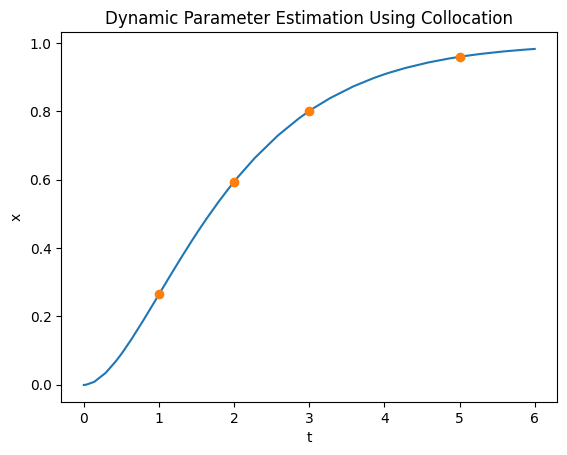

In [1]:
import pyomo.environ as pyo
from pyomo.dae import ContinuousSet, DerivativeVar

measurements = {1:0.264, 2:0.594, 3:0.801, 5:0.959}

model = pyo.ConcreteModel()
model.t = ContinuousSet(initialize=measurements.keys(),bounds=(0, 6))	

model.x1 = pyo.Var(model.t)
model.x2 = pyo.Var(model.t)

model.p1 = pyo.Var(bounds=(-1.5,1.5))
model.p2 = pyo.Var(bounds=(-1.5,1.5))

model.x1dot = DerivativeVar(model.x1,wrt=model.t)
model.x2dot = DerivativeVar(model.x2)

def _init_conditions(model):
	yield model.x1[0] == model.p1
	yield model.x2[0] == model.p2
model.init_conditions = pyo.ConstraintList(rule=_init_conditions)

# Alternate way to declare initial conditions
#def _initx1(model):
#	return model.x1[0] == model.p1		
#model.initx1 = pyo.Constraint(rule=_initx1)

#def _initx2(model):
#	return model.x2[0] == model.p2
#model.initx2 = pyo.Constraint(rule=_initx2)

def _x1dot(model,i):
	return model.x1dot[i] == model.x2[i]
model.x1dotcon = pyo.Constraint(model.t, rule=_x1dot)

def _x2dot(model,i):
	return model.x2dot[i] == 1-2*model.x2[i]-model.x1[i]
model.x2dotcon = pyo.Constraint(model.t, rule=_x2dot)

def _obj(model):
	return sum((model.x1[i]-measurements[i])**2 for i in measurements.keys())
model.obj = pyo.Objective(rule=_obj)

# Discretize model using Orthogonal Collocation
discretizer = pyo.TransformationFactory('dae.collocation')
discretizer.apply_to(model,nfe=8,ncp=5)

solver=pyo.SolverFactory('ipopt')

results = solver.solve(model,tee=True)

t_meas = sorted(list(measurements.keys()))
x1_meas = [pyo.value(measurements[i]) for i in sorted(measurements.keys())]

t = list(model.t)
x1 = [pyo.value(model.x1[i]) for i in model.t]
    
import matplotlib.pyplot as plt

plt.plot(t,x1)
plt.plot(t_meas,x1_meas,'o')
plt.xlabel('t')
plt.ylabel('x')
plt.title('Dynamic Parameter Estimation Using Collocation')
plt.show()
